In [2]:
# =========================
# Cell 0 — Setup & Config
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- EDIT THESE PATHS ----------
SECURE_CSV = r"SECURE_DBS/3-SECUREBERT_ENRICHED_IOC_DATASET.csv"
DISTIL_CSV = r"3-DISTILBERT_ENRICHED_IOC_DATASET.csv"

# ---------- COLUMN NAMES (EDIT IF NEEDED) ----------
COL_IOC   = "ioc_value"
COL_TYPE  = "ioc_type"
COL_CHAT  = "chat_name"
COL_TOPIC = "topic"

# VirusTotal fields (change here if your dataset uses different names)
COL_VT_MAL = "vt_malicious"      # e.g., could be "vt_score"
COL_VT_TOT = "vt_total_engines"  # optional but recommended

# Malicious definition (as you requested: vt_score > 0)
MALICIOUS_THRESHOLD = 0  # malicious if vt_malicious > 0

# Output folder for report figures
OUT_DIR = "report_figs"
import os
os.makedirs(OUT_DIR, exist_ok=True)

def load_enriched(path: str, source_name: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["source_model"] = source_name
    # basic cleanup
    for c in [COL_IOC, COL_TYPE, COL_CHAT, COL_TOPIC]:
        if c in df.columns:
            df[c] = df[c].astype(str)
    # ensure VT fields exist
    if COL_VT_MAL not in df.columns:
        raise ValueError(f"Missing column '{COL_VT_MAL}' in {source_name} dataset.")
    return df

def is_malicious(df: pd.DataFrame) -> pd.Series:
    # vt_malicious > 0
    return pd.to_numeric(df[COL_VT_MAL], errors="coerce").fillna(0) > MALICIOUS_THRESHOLD

def normalize_ioc_type(s: pd.Series) -> pd.Series:
    # Optional normalization to make types comparable
    # Adjust mapping if needed (e.g., ipv4 vs ip4)
    mapping = {
        "ipv4": "ip4",
        "ip": "ip4",
        "domain": "fqdn"
    }
    ss = s.astype(str).str.lower().str.strip()
    return ss.replace(mapping)

secure = load_enriched(SECURE_CSV, "SecureBERT")
distil = load_enriched(DISTIL_CSV, "DistilBERT")

secure[COL_TYPE] = normalize_ioc_type(secure[COL_TYPE])
distil[COL_TYPE] = normalize_ioc_type(distil[COL_TYPE])

print(f"Loaded SecureBERT: {len(secure):,} rows")
print(f"Loaded DistilBERT: {len(distil):,} rows")


Loaded SecureBERT: 499 rows
Loaded DistilBERT: 500 rows



MALICIOUS IoC SET OVERLAP (UNIQUE IoCs)


,Set,Unique_IoCs,Ratio_on_total_unique,Ratio_over_union_mal
0,SecureBERT (malicious),39,0.078156,NaN
1,DistilBERT (malicious),27,0.054000,NaN
2,Union (malicious),52,0.064677,NaN
3,Intersection (malicious),14,NaN,0.269231
4,Only SecureBERT (malicious),25,NaN,NaN
5,Only DistilBERT (malicious),13,NaN,NaN


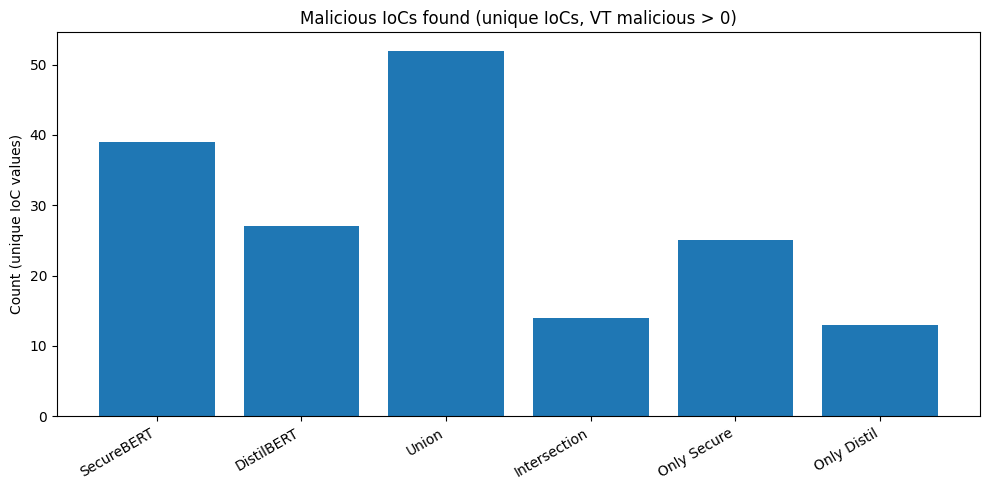

In [3]:
# =========================
# Cell 1 — Malicious overlap metrics (unique IoCs)
# =========================

# Unique IoC sets per model (you can decide to dedup only on ioc_value)
secure_iocs_all = set(secure[COL_IOC].dropna().unique())
distil_iocs_all = set(distil[COL_IOC].dropna().unique())

secure_mal = secure[is_malicious(secure)].copy()
distil_mal = distil[is_malicious(distil)].copy()

secure_iocs_mal = set(secure_mal[COL_IOC].dropna().unique())
distil_iocs_mal = set(distil_mal[COL_IOC].dropna().unique())

# Set operations (malicious IoCs)
inter_mal = secure_iocs_mal & distil_iocs_mal
union_mal = secure_iocs_mal | distil_iocs_mal

only_secure_mal = secure_iocs_mal - distil_iocs_mal
only_distil_mal = distil_iocs_mal - secure_iocs_mal

# Ratios "on total" (interpreted as: malicious unique IoCs / total unique IoCs per model)
ratio_secure = (len(secure_iocs_mal) / len(secure_iocs_all)) if len(secure_iocs_all) else 0
ratio_distil = (len(distil_iocs_mal) / len(distil_iocs_all)) if len(distil_iocs_all) else 0

# Union ratio on union total unique IoCs (across both models)
union_all = secure_iocs_all | distil_iocs_all
ratio_union = (len(union_mal) / len(union_all)) if len(union_all) else 0

# Intersection ratio: fraction of malicious union that both models share
ratio_inter_over_union_mal = (len(inter_mal) / len(union_mal)) if len(union_mal) else 0

summary = pd.DataFrame([
    {"Set": "SecureBERT (malicious)", "Unique_IoCs": len(secure_iocs_mal), "Ratio_on_total_unique": ratio_secure},
    {"Set": "DistilBERT (malicious)", "Unique_IoCs": len(distil_iocs_mal), "Ratio_on_total_unique": ratio_distil},
    {"Set": "Union (malicious)",      "Unique_IoCs": len(union_mal),       "Ratio_on_total_unique": ratio_union},
    {"Set": "Intersection (malicious)", "Unique_IoCs": len(inter_mal),    "Ratio_over_union_mal": ratio_inter_over_union_mal},
    {"Set": "Only SecureBERT (malicious)", "Unique_IoCs": len(only_secure_mal)},
    {"Set": "Only DistilBERT (malicious)", "Unique_IoCs": len(only_distil_mal)},
])

print("\n==============================")
print("MALICIOUS IoC SET OVERLAP (UNIQUE IoCs)")
print("==============================")
display(summary)

# ---- Plot 1: counts ----
counts = {
    "SecureBERT": len(secure_iocs_mal),
    "DistilBERT": len(distil_iocs_mal),
    "Union": len(union_mal),
    "Intersection": len(inter_mal),
    "Only Secure": len(only_secure_mal),
    "Only Distil": len(only_distil_mal),
}

plt.figure(figsize=(10, 5))
plt.bar(list(counts.keys()), list(counts.values()))
plt.title("Malicious IoCs found (unique IoCs, VT malicious > 0)")
plt.ylabel("Count (unique IoC values)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "malicious_ioc_overlap_counts.png"), dpi=200)
plt.show()



TABLE: Malicious IoC volume per group (unique IoCs per group, union)


,Group name,Malicious unique IoCs
0,Mikrotik-Training,17
1,HTTP Injector,13
2,Чат доксеров,4
3,VirusCheck Chat,4
4,DDOS交流攻击,4
5,Hacking Realm,4
6,Теневой Даркнет Чат,2
7,HTTP Injector Chat,2
8,Only Dark,2
9,Хакеры |Чат| 𝓗𝓪𝓬𝓴𝓮𝓻𝓼 𝓬𝓱𝓪𝓽,1


C:\Users\apisp\AppData\Local\Temp\ipykernel_22228\1295095479.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=table_groups["Group name"], x=table_groups["Malicious unique IoCs"], palette="viridis")
C:\Users\apisp\AppData\Local\Temp\ipykernel_22228\1295095479.py:30: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\apisp\AppData\Local\Temp\ipykernel_22228\1295095479.py:30: UserWarning: Glyph 27969 (\N{CJK UNIFIED IDEOGRAPH-6D41}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\apisp\AppData\Local\Temp\ipykernel_22228\1295095479.py:30: UserWarning: Glyph 25915 (\N{CJK UNIFIED IDEOGRAPH-653B}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\apisp\AppData\Local\Temp\ipykernel_22228\1295095479.py:30: UserWarning: Glyph 20987 (\N{CJK UNIFIED IDEOGRAPH-5

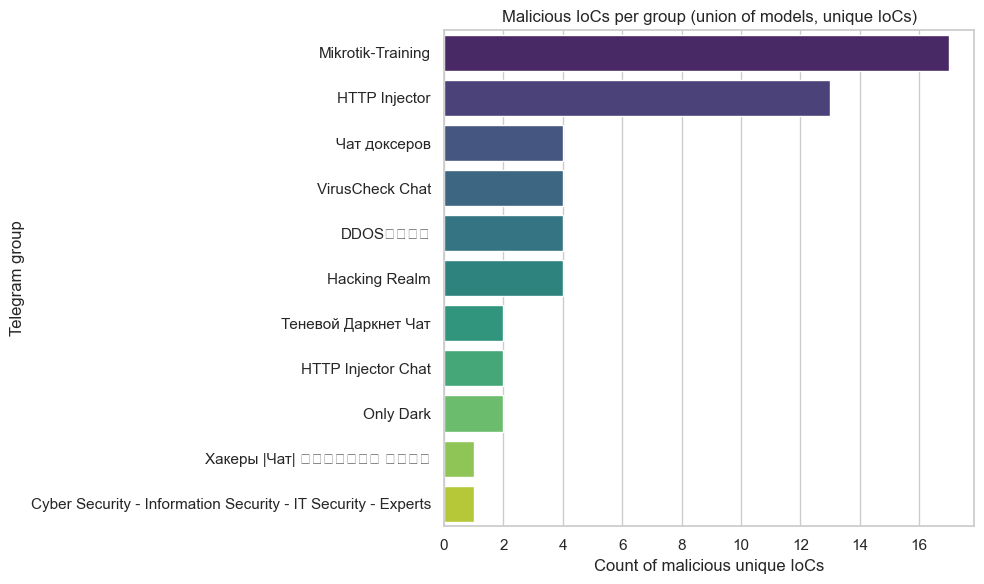

In [4]:
# =========================
# Cell 2 — Group volume (all groups, malicious only, union)
# =========================
import matplotlib.cm as cm
import seaborn as sns

# Union rows, malicious only
union_df = pd.concat([secure, distil], ignore_index=True)
union_df = union_df[is_malicious(union_df)].copy()

# Deduplicate across models within the same group (so the union isn't inflated)
# Each (chat_name, ioc_value) counted once
union_group_unique = union_df.drop_duplicates(subset=[COL_CHAT, COL_IOC]).copy()

group_counts = union_group_unique[COL_CHAT].value_counts()

print("\n==============================")
print("TABLE: Malicious IoC volume per group (unique IoCs per group, union)")
print("==============================")
table_groups = group_counts.reset_index()
table_groups.columns = ["Group name", "Malicious unique IoCs"]
display(table_groups)

sns.set_theme(style="whitegrid") 
plt.figure(figsize=(10, 6))
sns.barplot(y=table_groups["Group name"], x=table_groups["Malicious unique IoCs"], palette="viridis")
plt.title("Malicious IoCs per group (union of models, unique IoCs)")
plt.xlabel("Count of malicious unique IoCs")
plt.ylabel("Telegram group")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "malicious_iocs_per_group_union.png"), dpi=200)
plt.show()


In [14]:
# Calculate the percentage
# (x > 0).mean() calculates the ratio of True values, then we multiply by 100
union_df = pd.concat([secure, distil], ignore_index=True)
result = union_df.groupby('ioc_type')['vt_malicious'].apply(lambda x: (x > 0).mean() * 100)

print(result)

ioc_type
fqdn       8.896797
ip4       14.285714
md5        0.000000
sha1       0.000000
sha256     0.000000
url        2.680412
Name: vt_malicious, dtype: float64



TABLE: Distribuzione % IoC per Topic (Malicious)


ioc_type,fqdn,ip4,url
topic,,,
Darknet,60.87%,17.39%,21.74%
Software & Applications,22.73%,72.73%,4.55%
Technologies,28.57%,38.1%,33.33%


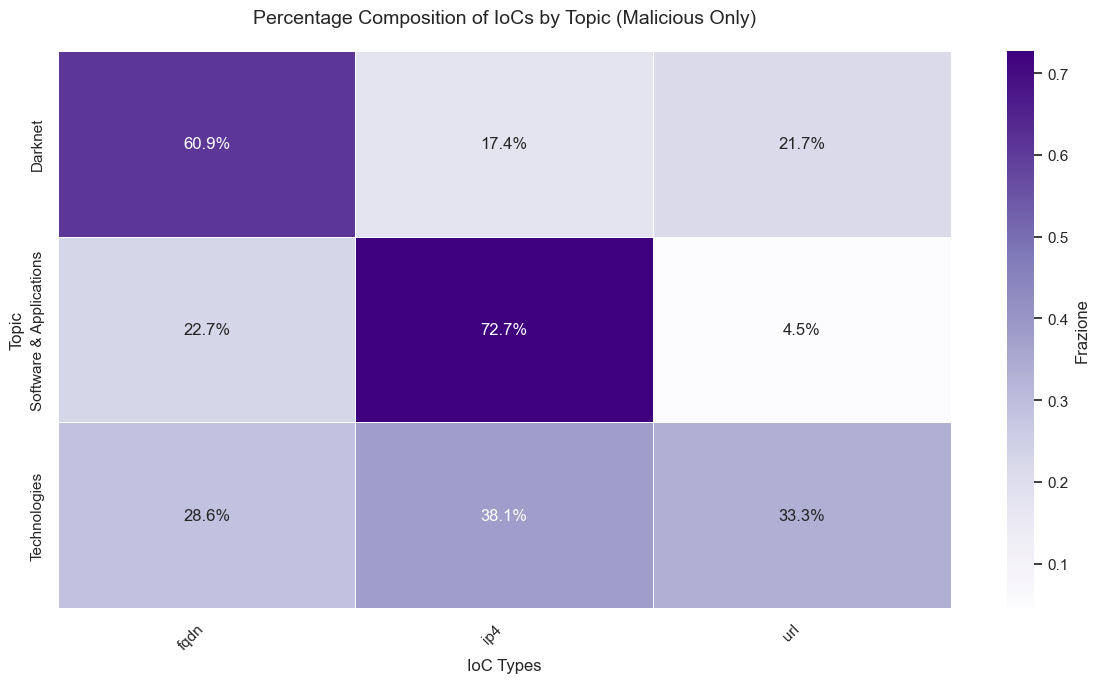

In [5]:
# =========================================================
# Cell 3 — Topic vs IoC type (%), malicious only, union
# =========================================================
import seaborn as sns

# 1. Prepariamo i dati (usando tutti i tipi disponibili nel df)
df_tm = union_df.copy()
df_tm[COL_TYPE] = normalize_ioc_type(df_tm[COL_TYPE])

# 2. Creiamo la crosstab normalizzata per riga (index)
# Questo calcola la frazione (0.0 a 1.0)
ct = pd.crosstab(df_tm[COL_TOPIC], df_tm[COL_TYPE], normalize="index")

# 3. Tabella testuale per log/controllo
print("\n==============================")
print("TABLE: Distribuzione % IoC per Topic (Malicious)")
print("==============================")
display((ct * 100).round(2).astype(str) + '%')

# 4. Grafico con Seaborn
plt.figure(figsize=(12, 7))

# Usiamo 'magma' o 'rocket' per un look cyber/professionale (scuro -> acceso)
# annot=True inserisce i numeri, fmt=".1%" trasforma 0.123 in 12.3%
sns.heatmap(
    ct, 
    annot=True, 
    fmt=".1%", 
    cmap="Purples", 
    linewidths=.5,
    cbar_kws={'label': 'Frazione'}
)

plt.title("Percentage Composition of IoCs by Topic (Malicious Only)", fontsize=14, pad=20)
plt.xlabel("IoC Types", fontsize=12)
plt.ylabel("Topic", fontsize=12)
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "topic_vs_type_heatmap_malicious_union.png"), dpi=200)
plt.show()


📊 DATA TABLE: Percentage Distribution: Top 6 IoC Types + Other per Topic
ioc_type_grouped           fqdn     ip4 phoneNumber telegramHandle     url    uuid   other
topic                                                                                     
Darknet                   18.1%    4.2%       31.5%          16.8%   16.9%    0.2%   12.3%
Software & Applications  18.44%  14.89%       0.07%          0.89%  41.73%  13.25%  10.72%
Technologies             23.07%   9.87%       0.29%          0.68%  44.18%   3.62%  18.28%


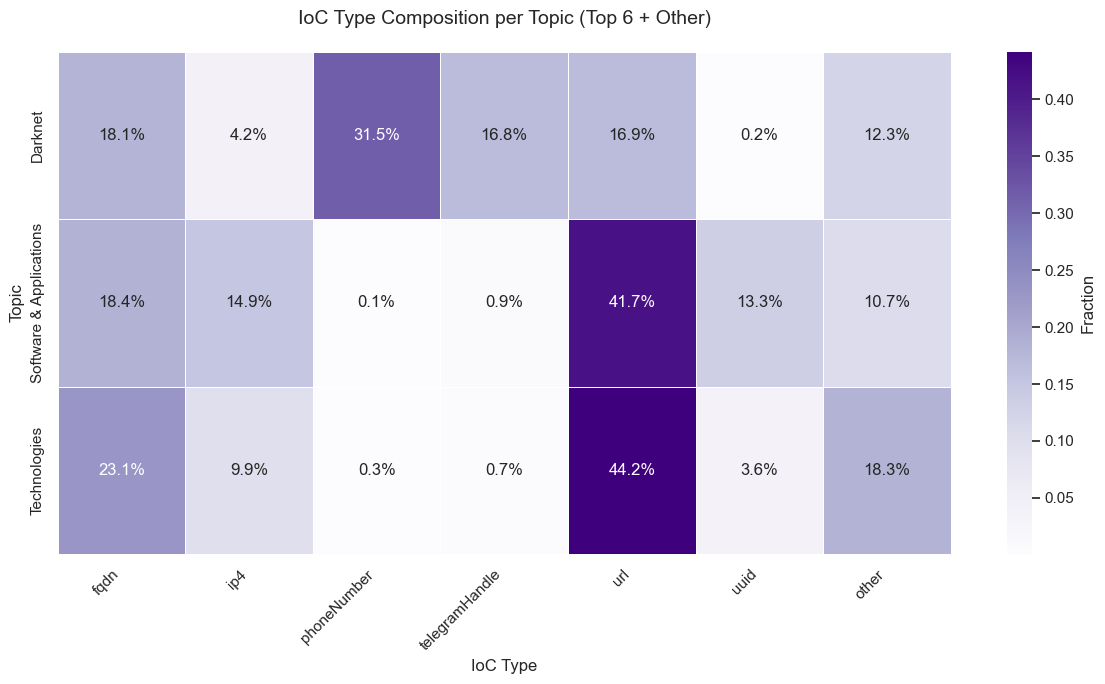


✅ Analysis Complete: Top 6 types identified and others grouped.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# =========================================================
# 1. CONFIGURATION & DATA MERGING
# =========================================================
# Load the two datasets
# Assuming the files are named 'IOC_DATASET.csv' in their respective folders
path1 = r"2-FIND_IOC_DATASET.csv"
path2 = r"SECURE_DBS/2-FIND_IOC_DATASET.csv"
df_distil = pd.read_csv(path1)
df_secure = pd.read_csv(path2)

# Union of the databases
df_union = pd.concat([df_distil, df_secure], ignore_index=True)

# Console display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

def print_table_header(title):
    print("\n" + "="*60)
    print(f"📊 DATA TABLE: {title}")
    print("="*60)

sns.set_theme(style="whitegrid")

# =========================================================
# 2. PRE-PROCESSING: TOP 6 + OTHER
# =========================================================
# Identify the top 6 most frequent IoC types
top_6_types = df_union['ioc_type'].value_counts().nlargest(6).index.tolist()

# Replace any type not in the top 6 with 'other'
df_union['ioc_type_grouped'] = df_union['ioc_type'].apply(
    lambda x: x if x in top_6_types else 'other'
)

# =========================================================
# 3. METRIC: Topic vs IoC Type % (TOP 6 + OTHER)
# =========================================================

# Create crosstab normalized by row
ct_grouped = pd.crosstab(df_union['topic'], df_union['ioc_type_grouped'], normalize='index')

# Reorder columns to put 'other' at the end for better visualization
cols = [c for c in ct_grouped.columns if c != 'other'] + ['other']
ct_grouped = ct_grouped[cols]

# -- PRINT TABLE --
print_table_header("Percentage Distribution: Top 6 IoC Types + Other per Topic")
print((ct_grouped * 100).round(2).astype(str) + '%')

# -- GRAPH (HEATMAP) --
plt.figure(figsize=(12, 7))

sns.heatmap(
    ct_grouped, 
    annot=True, 
    fmt=".1%", 
    cmap="Purples", 
    linewidths=.5,
    cbar_kws={'label': 'Fraction'}
)

plt.title("IoC Type Composition per Topic (Top 6 + Other)", fontsize=14, pad=20)
plt.ylabel("Topic", fontsize=12)
plt.xlabel("IoC Type", fontsize=12)
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
# plt.savefig('topic_vs_type_top6_heatmap.png', dpi=200)
plt.show()

print("\n" + "="*60)
print("✅ Analysis Complete: Top 6 types identified and others grouped.")